<a href="https://colab.research.google.com/github/github0apurva/DrugReview_NN/blob/master/DrugReview_co.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import numpy as np
np.random.seed(27)
import time as tp
import pandas as pd
import zipfile
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import os
import io
from bokeh.io import output_notebook
from bokeh.plotting import figure, show

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
import matplotlib.cm as cm

from google.colab import files
import re
import urllib
!pip install -q symspellpy
from symspellpy.symspellpy import SymSpell

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from sklearn.externals import joblib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Data Load**

In [4]:
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
r = requests.get(data_url, stream=True)
zf = zipfile.ZipFile(io.BytesIO(r.content))
train_raw = pd.read_csv( zf.open(zipfile.ZipFile.namelist(zf)[1]) , sep = "\t" )
test_raw = pd.read_csv( zf.open(zipfile.ZipFile.namelist(zf)[0]) , sep = "\t" )
train_raw.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


## Abstract:
The drug review dataset has 6 variables (excluding the unique identifier 'unnamed').

1. drugName (categorical): name of drug
2. condition (categorical): name of condition
3. review (text): patient review
4. rating (numerical): 10 star patient rating ( 1- 10 )
5. date (date): date of review entry (long format: month dd, yyyy )
6. usefulCount (numerical): number of users who found review useful 

The Training data has 160 thousand obervations and test has 50 thousand obervations. Both data has same variables.

# **DATA MANIPULATION FOR MODEL: Training**

In [5]:
# storing original data 
train_dat1 = train_raw.copy()
# removing the missing
train_dat1.dropna(axis = 0 , how = 'any' , inplace = True )
#creating new dependent with 3 classes
train_dat1['rating_3'] = np.where( train_dat1['rating'] > 7 , 3 , np.where ( train_dat1['rating'] > 3 , 2 , 1) )
train_dat1['rating3'] = train_dat1.rating_3.astype(object)
pd.crosstab(train_dat1.rating , train_dat1.rating_3 ) 

rating_3,1,2,3
rating,,,
1.0,21504,0,0
2.0,6879,0,0
3.0,6465,0,0
4.0,0,4980,0
5.0,0,7959,0
6.0,0,6301,0
7.0,0,9395,0
8.0,0,0,18791
9.0,0,0,27379


The 10 level ratings has been converted to 3 level indicating the extent/sentiment of the rating. 
1.   1-3: Demoter (identified as 0) 
2.   4-7: Neutral (identified as 1)
3.   8-10: Promoter (identified as 2)

## drugName variable grouping for dummy variable creation

In [0]:
#@title
# 20 outof 3436 : with atleast .5% count
drugName_list = train_dat1.drugName.value_counts()[0:30].index
train_dat1['drugName1'] = [ x if x in  drugName_list else 'Others' for x in train_dat1.drugName ]
train_dat1.drugName1.value_counts()/len(train_dat1)

In [0]:
#@title
drugName_ct = pd.crosstab( train_dat1.drugName1 , train_dat1.rating3 , normalize = 'index' )
drugName_ct.sort_values([1,2] , axis = 0, inplace = True )
# Adding legend for stack plots is tricky.
plt.plot([], [], color='r', label = 'D 1')
plt.plot([], [], color='g', label = 'D 2')
plt.plot([], [], color='b', label = 'D 3')
plt.stackplot(drugName_ct.index, drugName_ct[1], drugName_ct[2], drugName_ct[3], colors= ['r', 'g', 'b'])
plt.title('Stack Plot Example')
plt.legend()
plt.show()

In [6]:
#@title
drugName_ct = pd.DataFrame(data = pd.crosstab( train_dat1.drugName , train_dat1.rating3 , normalize = 'index')  ) 
print (drugName_ct.shape)
print ( drugName_ct[:10] )
drugName_wt = np.array(100* train_dat1.drugName.value_counts().sort_index() / len (train_dat1)  ) 
print ( drugName_wt[:10] )
principalDf = drugName_ct.reset_index().drop ( ['drugName'], axis = 1 )
p = 3

(3431, 3)
rating3                                      1         2         3
drugName                                                          
A + D Cracked Skin Relief             0.000000  0.000000  1.000000
A / B Otic                            0.000000  0.000000  1.000000
Abacavir / dolutegravir / lamivudine  0.057692  0.250000  0.692308
Abacavir / lamivudine / zidovudine    0.000000  0.000000  1.000000
Abatacept                             0.210526  0.210526  0.578947
Abilify                               0.260090  0.210762  0.529148
Abilify Discmelt                      0.000000  0.000000  1.000000
Abilify Maintena                      0.250000  0.000000  0.750000
Abiraterone                           0.000000  0.111111  0.888889
AbobotulinumtoxinA                    0.000000  0.333333  0.666667
[0.00062345 0.00062345 0.03241936 0.00062345 0.01184553 0.27805833
 0.0012469  0.0024938  0.00561104 0.00187035]


In [0]:
#@title

#pca_new = IncrementalPCA( n_components=p , copy = True, whiten = True)
#principalComponents = pca_new.fit_transform(drugName_ct1)
#principalDf = pd.DataFrame(data = principalComponents )


def cluster_multirun (principalDf, last_cluster_size, first_cluster_size, p, wght  ):
  diff = last_cluster_size - first_cluster_size
  labels = np.zeros((principalDf.shape[0],diff))
  sil_val = np.zeros((principalDf.shape[0],diff))
  inertia = []
  sil_avg = []
  cent = np.zeros((last_cluster_size,p,diff))
  for i in range (first_cluster_size,last_cluster_size):
      km = KMeans(n_clusters = i ) #, random_state = 27)
      km = km.fit(principalDf,wght)
      l = km.predict(principalDf,wght )
      labels[:,i-first_cluster_size] = l
      c = km.cluster_centers_
      cent[0:i,:,i-first_cluster_size] = c
      sil_avg.append(silhouette_score(principalDf, l))
      sil_val[:,i-first_cluster_size] = silhouette_samples(principalDf, l)
      inertia.append(km.inertia_ )
      print (i)
  return labels, inertia, sil_val, sil_avg, cent

In [0]:
#@title
last_cluster_size = 10 + 1
first_cluster_size = 2
labels, inertia, sil_val, sil_avg, cent = cluster_multirun (principalDf, last_cluster_size, first_cluster_size, p, drugName_wt )

2
3
4
5
6
7
8
9
10


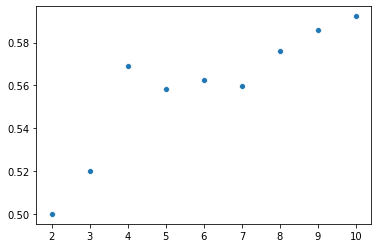

In [0]:
#@title
sns.scatterplot( x = [i for i in range (first_cluster_size,last_cluster_size)], y = sil_avg ) 
# 10 looks to be global maxima

For n_clusters = 2 The average silhouette_score is : 0.5001103264937572
For n_clusters = 3 The average silhouette_score is : 0.5200815501311024
For n_clusters = 4 The average silhouette_score is : 0.5689460700224964
For n_clusters = 5 The average silhouette_score is : 0.5583439318052841
For n_clusters = 6 The average silhouette_score is : 0.5623978513838385
For n_clusters = 7 The average silhouette_score is : 0.5598981492417174
For n_clusters = 8 The average silhouette_score is : 0.5761158963007007
For n_clusters = 9 The average silhouette_score is : 0.5856734583547505
For n_clusters = 10 The average silhouette_score is : 0.5922601224960712


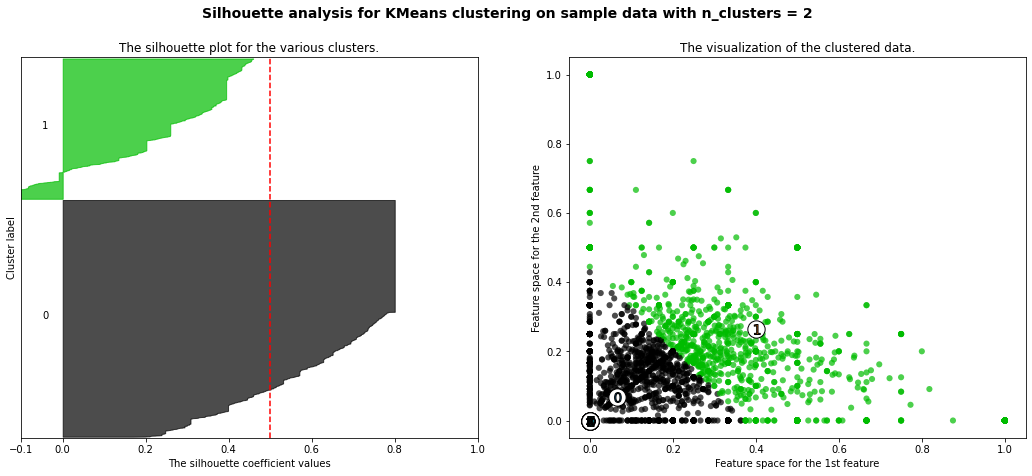

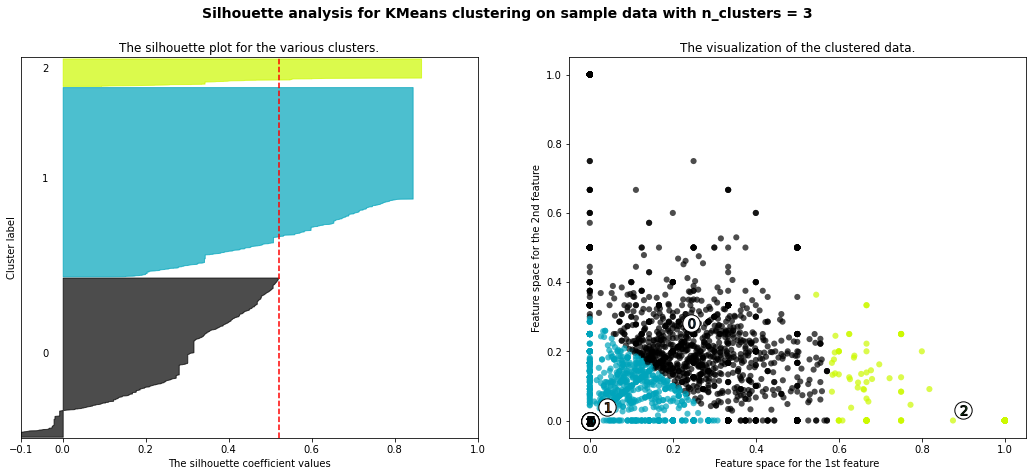

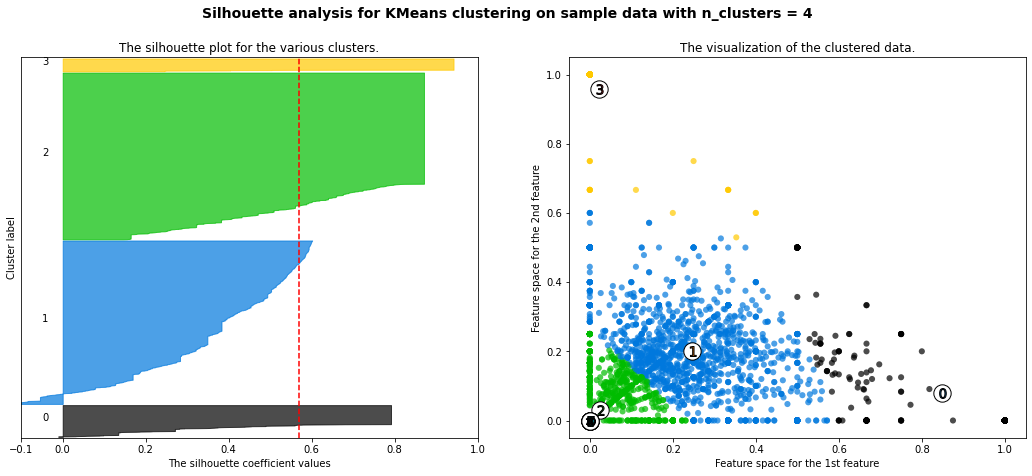

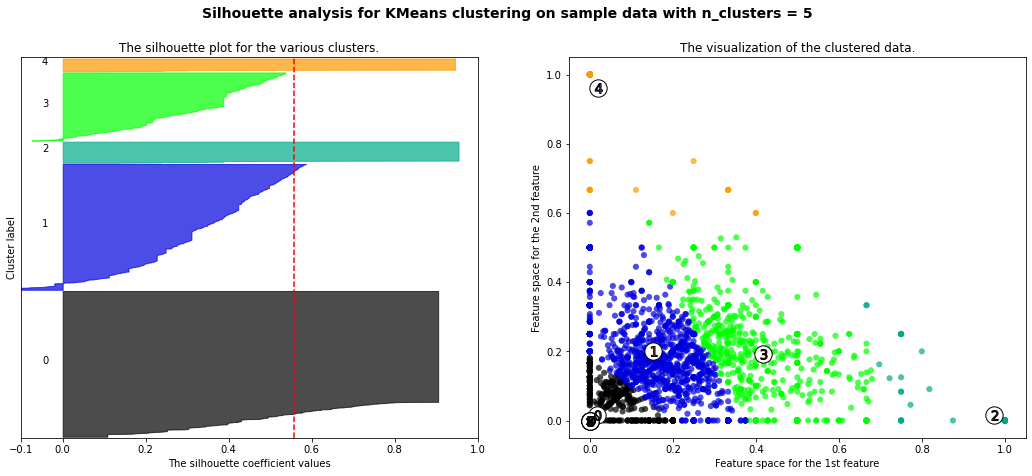

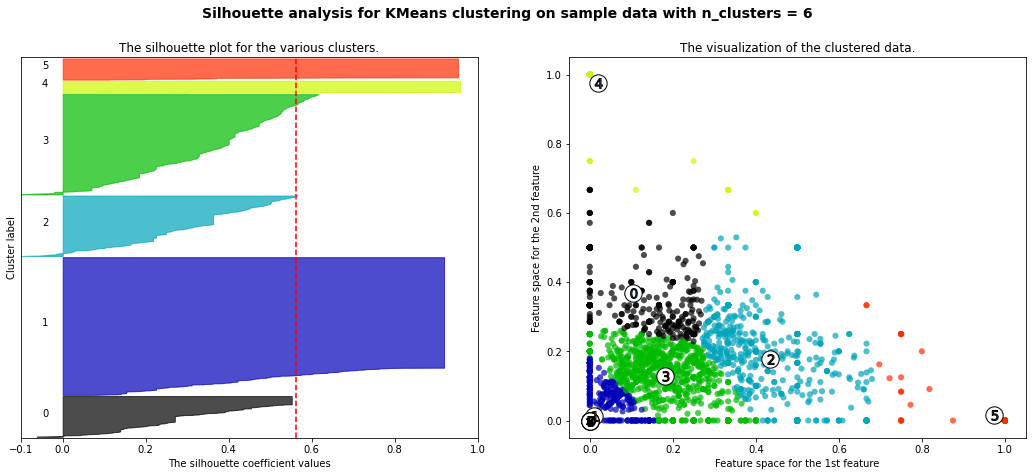

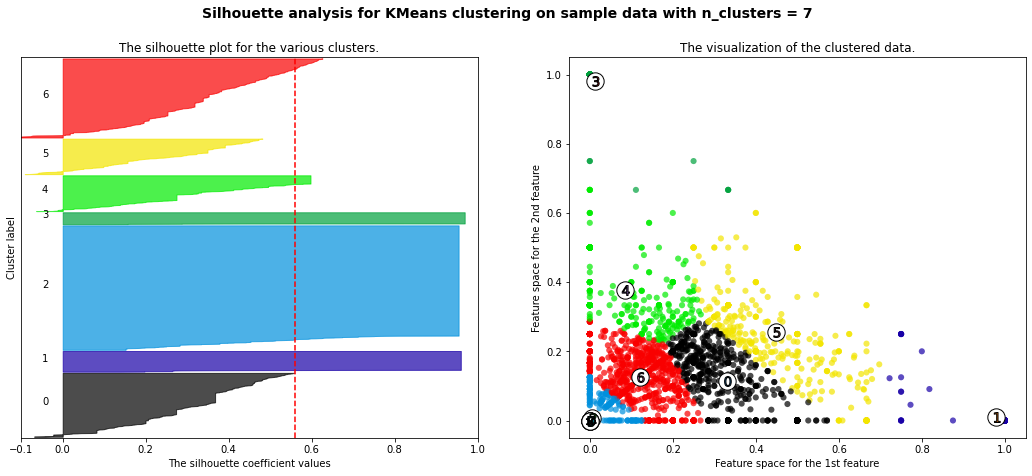

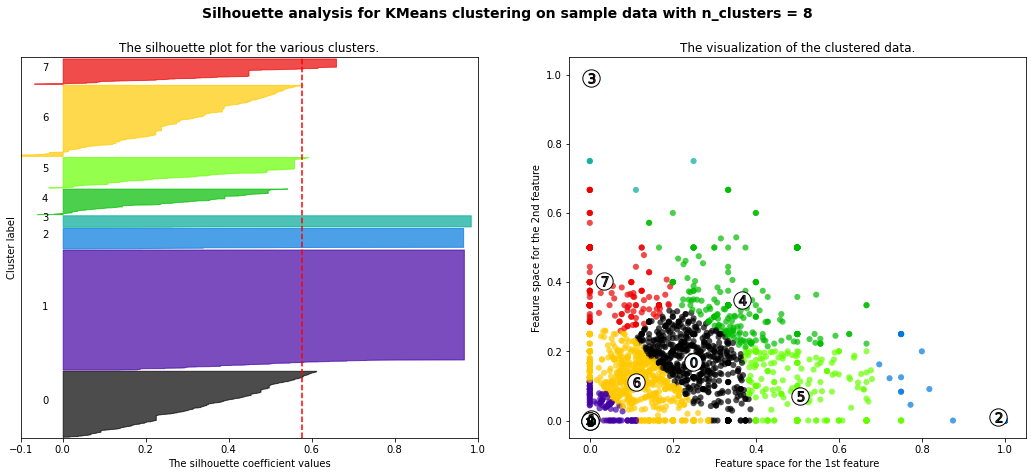

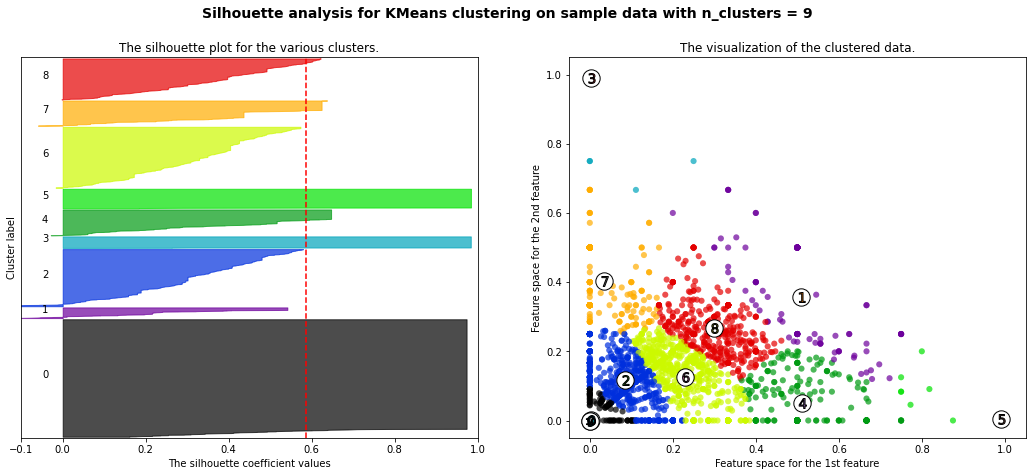

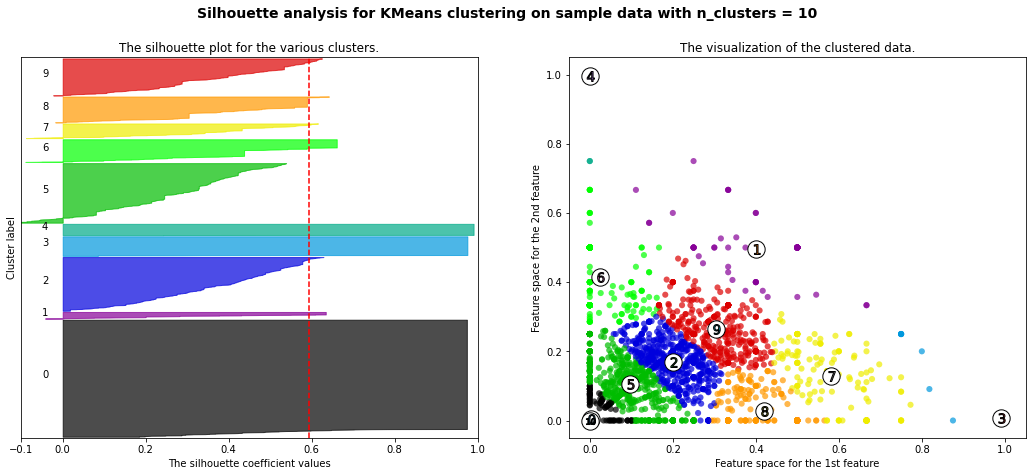

In [0]:
#@title

def cluster_sel (X, first_cluster_size, last_cluster_size , labels, sil_avg, sil_val):
  for n_clusters in range(first_cluster_size,last_cluster_size):
      # Create a subplot with 1 row and 2 columns
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.set_size_inches(18, 7)
      ax1.set_xlim([-0.1, 1])
      ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
      
      cluster_labels = labels[:,n_clusters-2]
      silhouette_avg = sil_avg[n_clusters-2]
      print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
      sample_silhouette_values = sil_val[:,n_clusters-2]
      
      y_lower = 10
      for i in range(n_clusters):
          ith_cluster_silhouette_values = \
              sample_silhouette_values[cluster_labels == i]
          ith_cluster_silhouette_values.sort()
          size_cluster_i = ith_cluster_silhouette_values.shape[0]
          y_upper = y_lower + size_cluster_i

          color = cm.nipy_spectral(float(i) / n_clusters)
          ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)
          ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
          y_lower = y_upper + 10  # 10 for the 0 samples
      
      ax1.set_title("The silhouette plot for the various clusters.")
      ax1.set_xlabel("The silhouette coefficient values")
      ax1.set_ylabel("Cluster label")
      ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
      ax1.set_yticks([])  # Clear the yaxis labels / ticks
      ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

      # 2nd Plot showing the actual clusters formed
      colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
      ax2.scatter(X[1], X[2], marker='.', s=150, lw=0, alpha=0.7, c=colors, edgecolor='k')
      centers = cent[:, : , n_clusters-2]
      ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=300, edgecolor='k')
      for i, c in enumerate(centers):
          ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=100, edgecolor='k')
      ax2.set_title("The visualization of the clustered data.")
      ax2.set_xlabel("Feature space for the 1st feature")
      ax2.set_ylabel("Feature space for the 2nd feature")
      plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                  fontsize=14, fontweight='bold')

  plt.show()
  return

cluster_sel (principalDf, first_cluster_size,  last_cluster_size, labels, sil_avg, sil_val )

drugName

Decided to take n = 10 or 4 

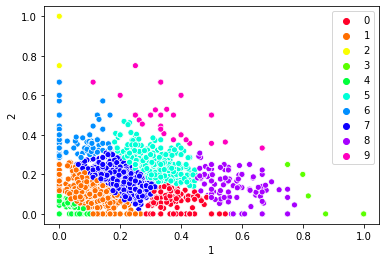

In [7]:
kmf = KMeans(n_clusters = 10, n_init = 20 )
kmf = kmf.fit(principalDf,drugName_wt)
labels = kmf.predict(principalDf,drugName_wt)
ax = sns.scatterplot(x=principalDf[1], y=principalDf[2], hue=labels , palette = "gist_rainbow" , legend = 'full')

In [8]:
# l = pd.DataFrame( data = ( np.where(labels == 0,"zero", 
#               np.where (labels == 1 , "onethree", 
#               np.where (labels == 2 , "twofive", 
#               np.where (labels == 3 , "onethree", 
#               np.where (labels == 4 , "four",
#               np.where (labels == 5 , "twofive",
#                         "missing") )))))
#               .astype('object') ) , columns = ['lab'] , index = drugName_ct.index)

l = pd.DataFrame( data = labels.astype('object') , columns = ['lab'] , index = drugName_ct.index)
                                    
drug_clust = pd.concat([drugName_ct, l] , axis = 1 ,  sort = False)

print (drug_clust.shape)
drug_clust.tail()

(3431, 4)


,1,2,3,lab
drugName,,,,
Zyvox,0.000000,0.117647,0.882353,1
ZzzQuil,0.500000,0.500000,0.000000,9
depo-subQ provera 104,1.000000,0.000000,0.000000,3
ella,0.196078,0.196078,0.607843,7
femhrt,0.666667,0.000000,0.333333,8


In [9]:
train_dat2 = train_dat1.copy()
train_dat2['drugName_grp'] = [drug_clust.loc[x,'lab'] for x in train_dat2['drugName'] ]
train_dat2['drugName_grp'].value_counts()

7    61145
5    40843
1    38622
8     8152
4     5090
0     3774
6     1909
9      433
3      310
2      120
Name: drugName_grp, dtype: int64

In [10]:
pd.crosstab(train_dat2['drugName_grp']  , train_dat2['rating3'] , normalize = 'index' )

rating3,1,2,3
drugName_grp,,,
0,0.377583,0.069157,0.553259
1,0.092538,0.112863,0.794599
2,0.000000,0.983333,0.016667
3,0.961290,0.029032,0.009677
4,0.019057,0.025344,0.955599
5,0.320373,0.245623,0.434003
6,0.072813,0.368779,0.558408
7,0.189222,0.187865,0.622913
8,0.552870,0.163518,0.283611


In [0]:
param_out = {}
param_out['drugName_grp'] = drug_clust

## condition variable grouping for dummy variable creation

In [0]:
#@title
# 40 outof 885 : with atleast 1% count
condition_list = train_dat1.condition.value_counts()[0:21].index
train_dat1['condition1'] = [ x if x in  condition_list else 'Others' for x in train_dat1.condition ]
train_dat1.condition1.value_counts()/len(train_dat1)

In [0]:
#@title
condition_ct = pd.crosstab( train_dat1.condition1 , train_dat1.rating3 , normalize = 'index' )
condition_ct.sort_values([1,2] , axis = 0, inplace = True )
# Adding legend for stack plots is tricky.
plt.plot([], [], color='r', label = 'D 1')
plt.plot([], [], color='g', label = 'D 2')
plt.plot([], [], color='b', label = 'D 3')
plt.stackplot(condition_ct.index, condition_ct[1], condition_ct[2], condition_ct[3], colors= ['r', 'g', 'b'])
plt.title('Stack Plot Example')
plt.legend()
plt.show()

In [12]:
k = lambda x: 'users found this comment helpful' in x
train_dat1['condition2'] = np.where ( list ( map ( k, train_dat1['condition'] ) ), 'users found this comment helpful' , train_dat1.condition )
train_dat1.condition2.value_counts().tail(20)
train_dat2['condition2'] = train_dat1['condition2'] 

condition_ct = pd.DataFrame(data = pd.crosstab( train_dat1.condition2 , train_dat1.rating3 , normalize = 'index') )
print (condition_ct.shape)
print ( condition_ct[:10] )
condition_wt = np.array(100* train_dat1.condition2.value_counts().sort_index() / len (train_dat1)  ) 
print ( condition_wt[:10] )
p = 3
principalDf = condition_ct.reset_index().drop ( ['condition2'], axis = 1 )

(812, 3)
rating3                           1         2         3
condition2                                             
ADHD                       0.163760  0.183565  0.652675
AIDS Related Wasting       0.200000  0.200000  0.600000
AV Heart Block             1.000000  0.000000  0.000000
Abdominal Distension       0.000000  0.000000  1.000000
Abnormal Uterine Bleeding  0.517653  0.204676  0.277672
Abortion                   0.142857  0.142857  0.714286
Acetaminophen Overdose     0.000000  0.000000  1.000000
Acne                       0.176807  0.165712  0.657480
Actinic Keratosis          0.241379  0.068966  0.689655
Acute Coronary Syndrome    0.259259  0.370370  0.370370
[2.10912854e+00 3.11724585e-03 6.23449170e-04 1.24689834e-03
 1.30674946e+00 4.36414419e-03 6.23449170e-04 3.48383396e+00
 1.80800259e-02 3.36662552e-02]


In [13]:
condition_ct.head(73)

rating3,1,2,3
condition2,,,
ADHD,0.163760,0.183565,0.652675
AIDS Related Wasting,0.200000,0.200000,0.600000
AV Heart Block,1.000000,0.000000,0.000000
Abdominal Distension,0.000000,0.000000,1.000000
Abnormal Uterine Bleeding,0.517653,0.204676,0.277672
...,...,...,...
Atrophic Urethritis,0.391304,0.304348,0.304348
Atrophic Vaginitis,0.379121,0.131868,0.489011
Auditory Processing Disorde,0.200000,0.400000,0.400000


In [0]:
#@title
last_cluster_size = 10 + 1
first_cluster_size = 2
labels, inertia, sil_val, sil_avg, cent = cluster_multirun (principalDf, last_cluster_size, first_cluster_size, p,condition_wt )



2
3
4
5
6
7
8
9
10


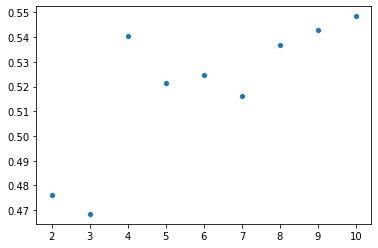

In [0]:
#@title
sns.scatterplot( x = [i for i in range (first_cluster_size,last_cluster_size)], y = sil_avg ) 
# 10 looks to be global maxima from the sample

For n_clusters = 2 The average silhouette_score is : 0.476029718751971
For n_clusters = 3 The average silhouette_score is : 0.4684596560132647
For n_clusters = 4 The average silhouette_score is : 0.5402921641326731
For n_clusters = 5 The average silhouette_score is : 0.5213790369420133
For n_clusters = 6 The average silhouette_score is : 0.5247608323797096
For n_clusters = 7 The average silhouette_score is : 0.5162862976057914
For n_clusters = 8 The average silhouette_score is : 0.5369834541063506
For n_clusters = 9 The average silhouette_score is : 0.5427878853260393
For n_clusters = 10 The average silhouette_score is : 0.548478821665836


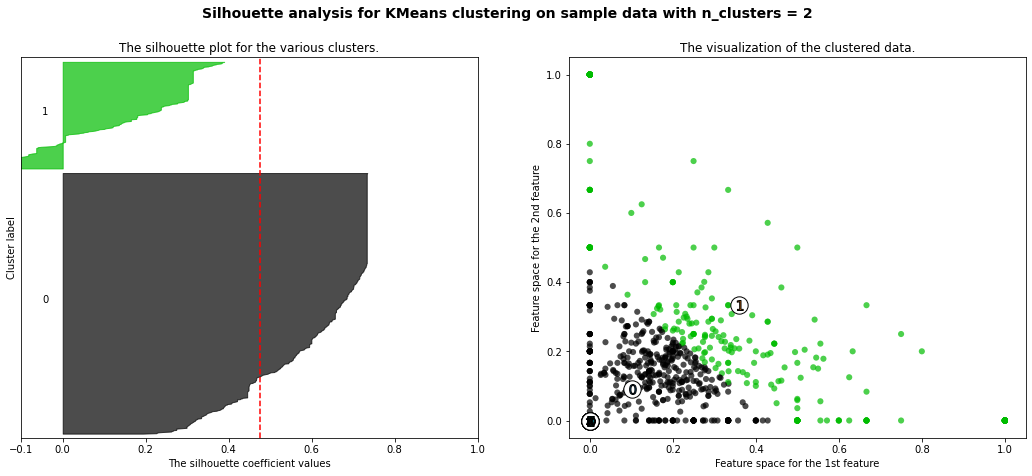

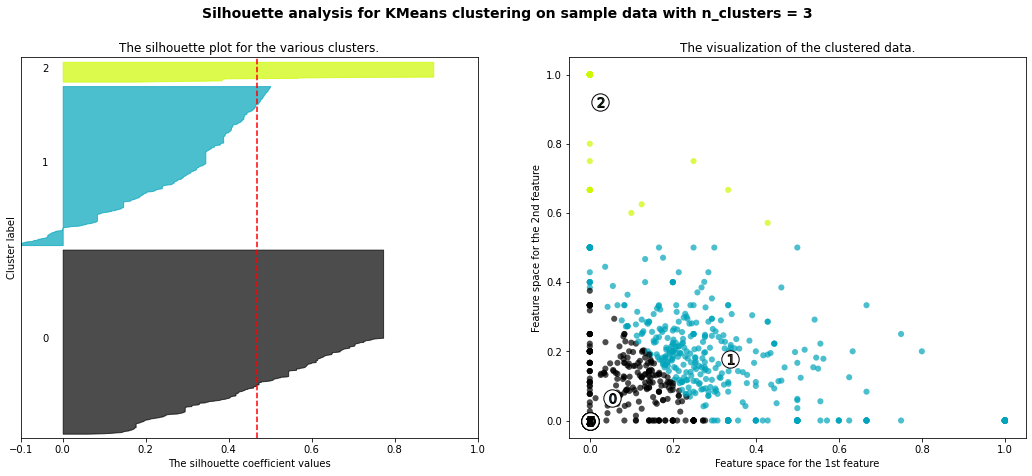

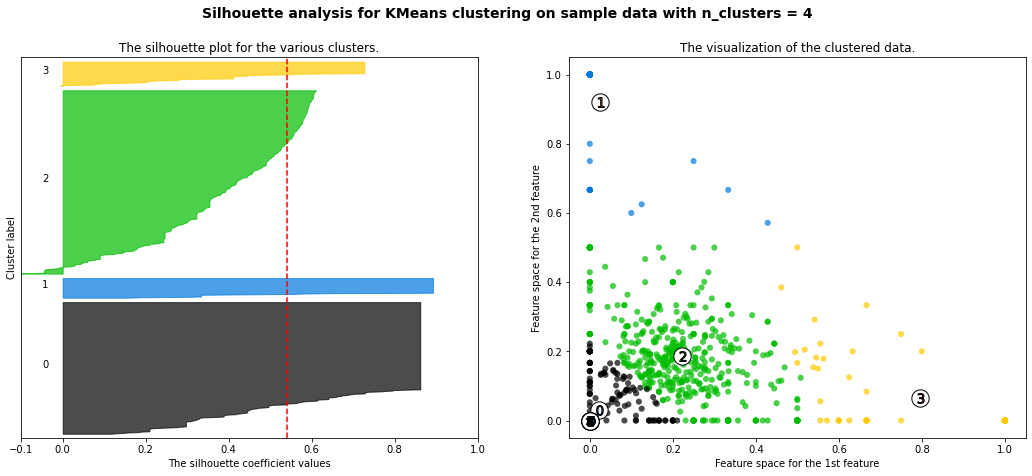

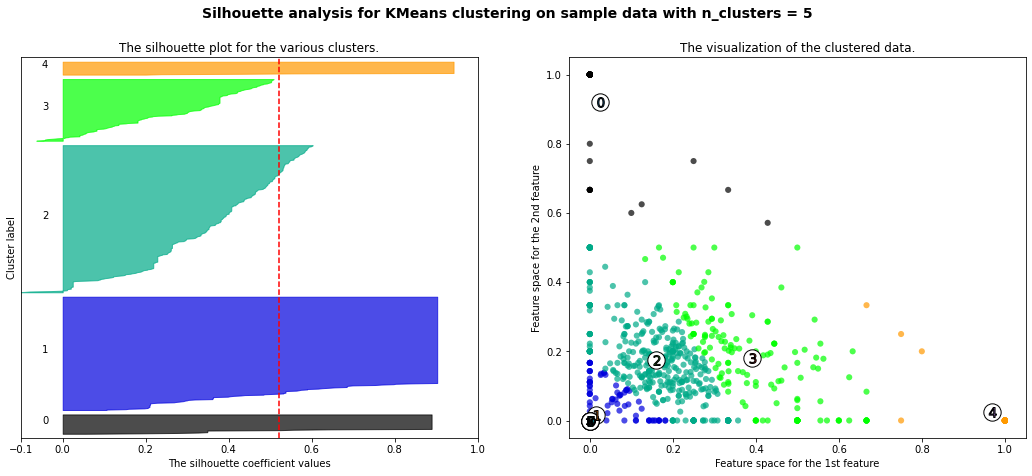

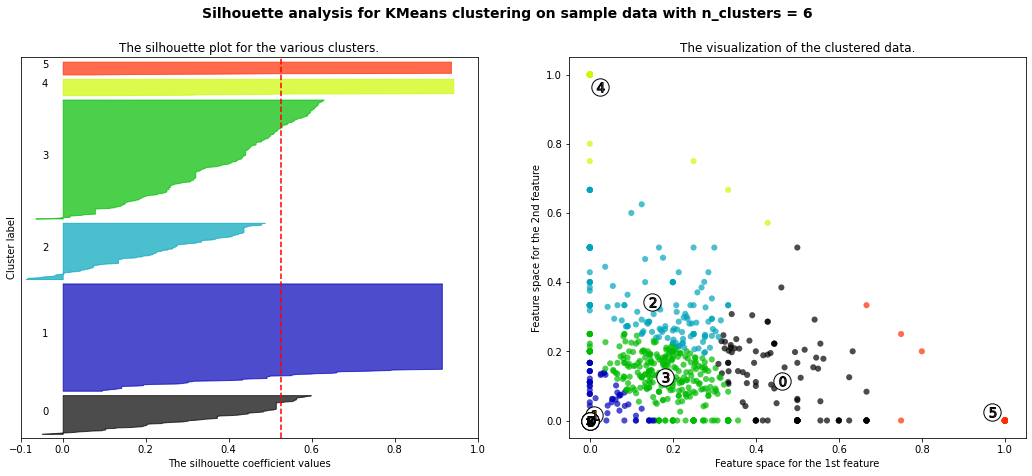

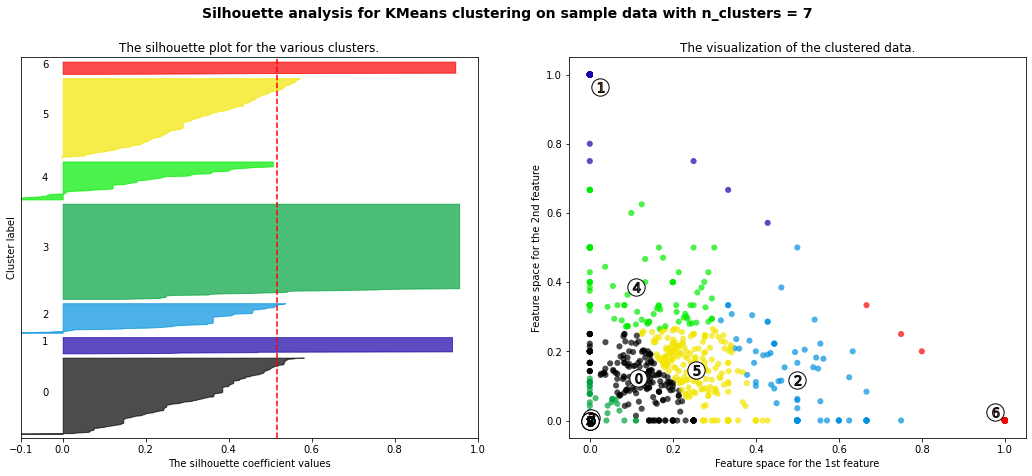

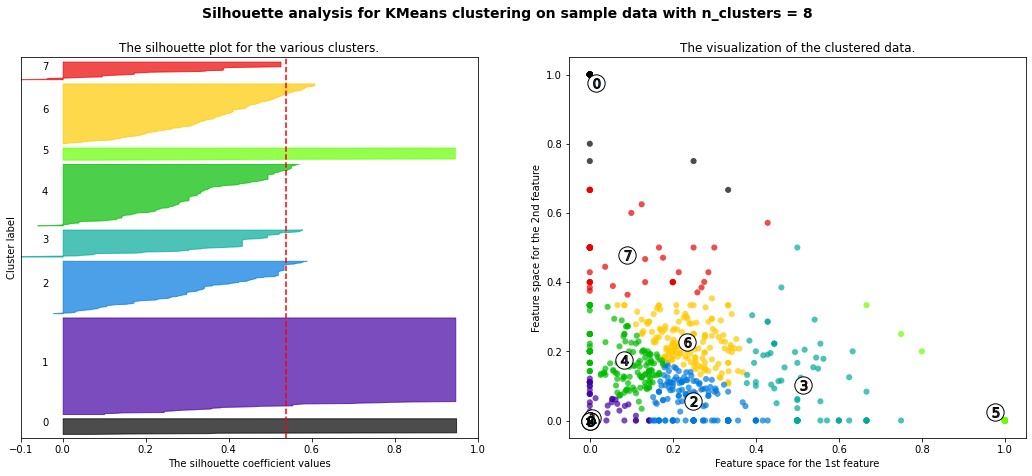

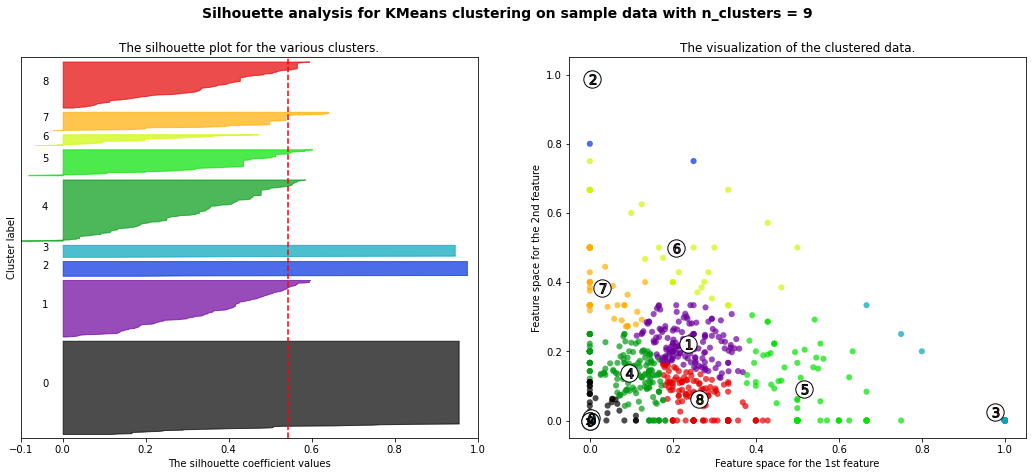

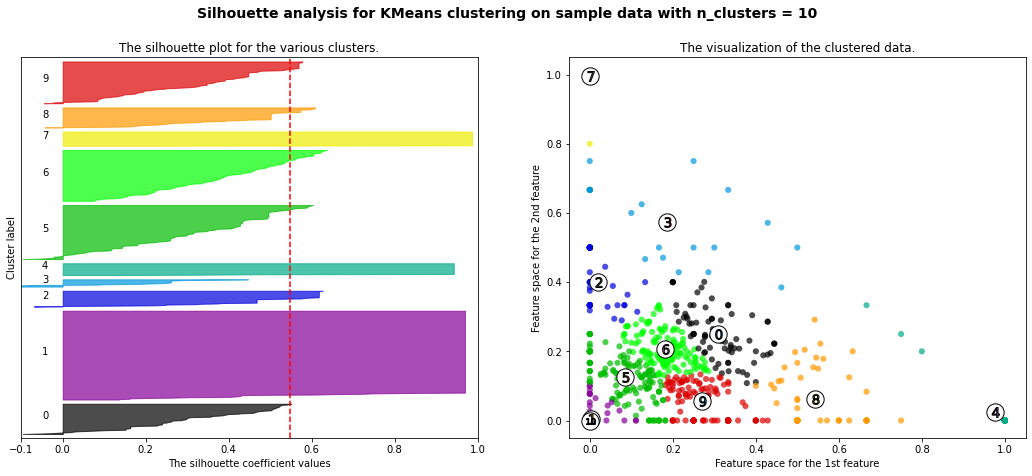

In [0]:
#@title
cluster_sel (principalDf, first_cluster_size,  last_cluster_size, labels, sil_avg, sil_val )

condition

Decided to take n = 9

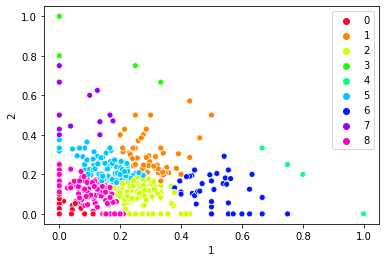

In [14]:
kmf = KMeans(n_clusters = 9, n_init = 20 )
kmf = kmf.fit(principalDf,condition_wt)
labels = kmf.predict(principalDf,condition_wt)
ax = sns.scatterplot(x=principalDf[1], y=principalDf[2], hue=labels , palette = "gist_rainbow" , legend = 'full')

In [0]:
# l = pd.DataFrame( data = ( np.where(labels == 0,"zeroone", 
#                   np.where (labels == 1 , "zeroone", 
#                   np.where (labels == 2 , "two", 
#                   np.where (labels == 3 , "threefive", 
#                   np.where (labels == 4 , "four",
#                   np.where (labels == 5 , "threefive",
#                             "missing") )))))
#                   .astype('object') ) , columns = ['lab'] , index = condition_ct.index)
l = pd.DataFrame( data = labels.astype('object')  , columns = ['lab'] , index = condition_ct.index)

In [16]:
cond_clust = pd.concat([condition_ct, l] , axis = 1 ,  sort = False)

print (cond_clust.shape)
cond_clust.tail()

(812, 4)


,1,2,3,lab
condition2,,,,
ungal Infection Prophylaxis,0.000000,1.000000,0.000000,3
ungal Pneumonia,1.000000,0.000000,0.000000,4
users found this comment helpful,0.224444,0.215556,0.560000,5
von Willebrand's Disease,0.000000,0.000000,1.000000,0
zen Shoulde,0.214286,0.214286,0.571429,5


In [17]:
train_dat2['condition_grp'] = [cond_clust.loc[x,'lab'] for x in train_dat2['condition2'] ]
train_dat2['condition_grp'].value_counts()

5    51462
8    41911
1    38763
2    18705
6     7853
0     1402
7      189
3       58
4       55
Name: condition_grp, dtype: int64

In [18]:
pd.crosstab(train_dat2['condition_grp']  , train_dat2['rating3'] , normalize = 'index' )

rating3,1,2,3
condition_grp,,,
0,0.014265,0.027817,0.957917
1,0.295823,0.246008,0.458169
2,0.255600,0.130393,0.614007
3,0.034483,0.948276,0.017241
4,0.945455,0.054545,0.000000
5,0.185652,0.194104,0.620244
6,0.500191,0.176875,0.322934
7,0.058201,0.497354,0.444444
8,0.120088,0.121472,0.758441


In [0]:
param_out['condition_grp'] = cond_clust

## working on text data and final data prep for modelling

In [20]:
train_dat2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160398 entries, 0 to 161296
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     160398 non-null  int64  
 1   drugName       160398 non-null  object 
 2   condition      160398 non-null  object 
 3   review         160398 non-null  object 
 4   rating         160398 non-null  float64
 5   date           160398 non-null  object 
 6   usefulCount    160398 non-null  int64  
 7   rating_3       160398 non-null  int64  
 8   rating3        160398 non-null  object 
 9   drugName_grp   160398 non-null  int64  
 10  condition2     160398 non-null  object 
 11  condition_grp  160398 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 15.9+ MB


In [0]:
#@title
train_dat2.to_csv('drug_colab.csv')
files.download('drug_colab.csv')

In [0]:
#@title
#uploaded = files.upload()
train_dat2 = pd.read_csv('drug_colab.csv')

In [0]:
#@title
train_dat2.drop(['Unnamed: 0'], axis = 1 , inplace = True)
train_dat2.head()

In [0]:
# function for reducing the repeat chars to a masx of 2. eg finallllllly to finally & lllllocal to llocal
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)
# utilize SymSpell for spelling correction


def filter_punc_stop_stem_words ( train_sentences ):
    # defining the stop words to be removed
    stop_words_sel = ( set(stopwords.words('english'))  - param_prep['stopwords_no'] )
    # removing the punctuation from the sentences
    train_sentences2 = [ train_sentences[x].translate(str.maketrans('','', punctuation)) for x in range (len(train_sentences))]
    # saving a copy for later use
    train_sentences3 = train_sentences2
    # calling an instance of porter stemmer
    ps = PorterStemmer()
    # klower case & stemming of all words
    # calling reduce_lengthening for decreasing repeat chars to max of 2
    for i, sen in enumerate(train_sentences2) :
        sent = [ ps.stem(reduce_lengthening(w.lower())) for w in sen.split() if w.lower() not in stop_words_sel ]
        train_sentences3[i] = ' '.join(sent)
    return train_sentences3

In [0]:
#@title
path1 = "https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt"
path2 = "https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_bigramdictionary_en_243_342.txt"

txt1 = urllib.request.urlopen(path1).read().decode('utf-8').splitlines()
wrd_cnt = pd.DataFrame(data = [  a.split()[0]  for a in txt1 ] , columns = ['word'])
wrd_cnt['cnt'] = [  int(a.split()[1])  for a in txt1 ]
wrd_cnt.head()

In [104]:
#wordfrequency_en.txt  ensures high correction quality by combining two data sources: 
#Google Books Ngram data  provides representative word frequencies (but contains many entries with spelling errors)  
#SCOWL — Spell Checker Oriented Word Lists which ensures genuine English vocabulary (but contained no word frequencies)
# have downloaded it to colab files
path01 = "frequency_dictionary_en_82_765.txt"
path02 = "frequency_bigramdictionary_en_243_342.txt"
#Load the frequency dictionaries
symspell = SymSpell()
symspell.load_dictionary(corpus = path01 , term_index = 0, count_index = 1 )
symspell.load_bigram_dictionary(corpus = path02 , term_index = 0, count_index = 2 )

True

In [113]:
# lookup suggestions for single-word input strings
input_term = "llocally"  # misspelling of "members"
max_edit_distance_lookup = 2
sugs = symspell.lookup(input_term , max_edit_distance_lookup)
for sug in sugs:
  print (sug.term, sug.distance, sug.count)

locally 1 9356689


In [117]:
# lookup suggestions for multi-word input strings
input_term = "whereis th elove hehad dated forImuch of thepast who couqdn'tread in sixtgrade and ins pired him"
max_edit_distance_lookup = 2
sugs = symspell.lookup_compound (input_term,  max_edit_distance_lookup)
for sug in sugs:
  print (sug.term, sug.distance, sug.count)

where is to love he had dated for much of ﻿the past who couldn't read in six grade and inspired him 11 0


Helper function for removing punctuation, stop words and stemming.

Removing Punctuation : Although punctuation can be automatically removed while using keras tokenizer, but since it was interacting with the stop words ( resulting in differnt words, eg 'it' vs '.it'), had to remove beforehand.

Removing stop words : Only removing neutral ones and not ones with 'no' ; as these embarks meaning to the sentence . List of retained stop words can be found with param_prep dcitionary.

Stemming the sentence : It has 80,000 + unique words. The thought process is to remove duplicate words as much as possible to retain a unique set of 10,000 words at end.
Used PorterStemmer as it is older, less aggressive, simple and fast.

In [0]:
def aux_data ( tr ):
    tr_aux1 = tr[['usefulCount' ,  'date', 'drugName_grp', 'condition_grp' ]]
    datef = pd.to_datetime(tr_aux1.date, errors='coerce')
    tr_aux1['date_year'] = datef.dt.year  
    tr_aux1['date_month'] = datef.dt.month
    tr_aux1['date_weekday'] = datef.dt.weekday

    tr_aux2 = pd.get_dummies(tr[[ 'drugName_grp', 'condition_grp']], prefix=['D', 'C'])
    tr_ax = pd.concat([tr_aux1, tr_aux2], axis = 1 )      
    tr_ax = tr_ax.drop(['date', 'drugName_grp', 'condition_grp' ], axis = 1 )
    return tr_ax

Helper function to create data for auxilliary input to the model

Apart from the text review, feeding factors like drugname, condition, review date and useful count.
Hence creating a seperate data for auxilliary input to layers of NN.

In [0]:
# parameters utilized while working on Data Manipulation
param_prep = {
        'vocab_size' : 10000 ,
        'max_length' : 100 ,
        'stopwords_no' : set({ 'no', 'not', 'but', "haven't", "weren't", "wasn't", "doesn't", 'off',
                      "hadn't", "mightn't", "couldn't", "shan't", "mustn't", "isn't", "won't",
                      "needn't", "don't", "didn't", "shouldn't", "wouldn't", "hasn't" }),
        'oov_tok' : "<OOV>" ,
        'padding_type' : 'post',
        'trunc_type' : 'post'
        }

In [0]:
# creating a list of all the reviews and subsequnetly removing punctuations and stopwords.
train_text = [x for x in train_dat2.review]
train_text1 = filter_punc_stop_stem_words ( train_text )

0.0018828164939712465


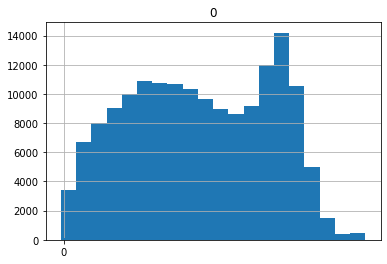

In [24]:
# calculating the size of total vocab, length of each text and frequency of each word
tokenizer = Tokenizer( oov_token = param_prep['oov_tok'] )
tokenizer.fit_on_texts(train_text1)
word_index = tokenizer.word_index
len(word_index)
# total vocab size: 67867
seq = tokenizer.texts_to_sequences(train_text1)
seq_len = []
for i in seq:
  seq_len.append(len(i))
pd.DataFrame( data = seq_len ).clip(0,100).hist(bins = 20 )
pd.DataFrame( data = seq_len ).clip(0,100).boxplot()
print ( len( [1 for x in seq_len if x > 100 ] ) / len (seq_len) )
# With median of 45 words, most (99.9%) of the texts are within 100

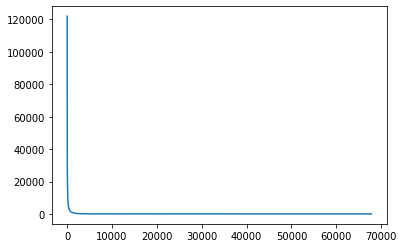

In [62]:
seq_ravel = [item for sublist in seq for item in sublist ] 
word_index_df = pd.DataFrame.from_dict( data = word_index , orient = 'index', columns=['word_index'])
word_index_df.reset_index(inplace = True)
word_index_df.rename (columns= {'index':'word'}, inplace = True)
seq_ravel_df = pd.DataFrame( data = seq_ravel, columns =['seq_ravel'] )
seq_ravel_df_df = seq_ravel_df.seq_ravel.value_counts()
seq_ravel_df_df = seq_ravel_df_df.reset_index()
word_index_df_df = word_index_df.merge(seq_ravel_df_df, how = 'inner', left_on = 'word_index', right_on = 'index')
seq_ravel_df_df.seq_ravel.plot.line()

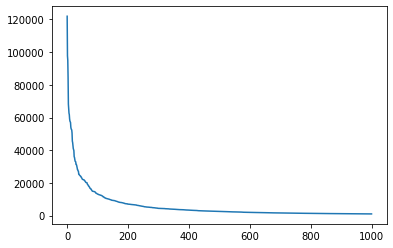

In [107]:
# deciding on the vocab size
seq_ravel_df_df[0:1000].seq_ravel.plot.line()

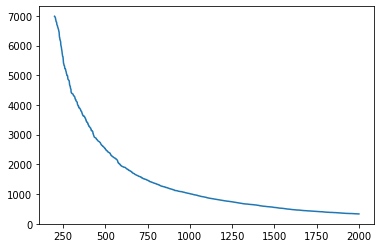

In [63]:
seq_ravel_df_df[200:2000].seq_ravel.plot.line()

In [71]:
word_index_df_df.tail(20)

,word,word_index,index,seq_ravel
67846,nuasea,67848,67848,1
67847,featuresnearli,67849,67849,1
67848,geodon039,67850,67850,1
67849,75year,67851,67851,1
67850,anklesboth,67852,67852,1
67851,hopefulmoder,67853,67853,1
67852,agewhat,67854,67854,1
67853,sobergood,67855,67855,1
67854,pukequot,67856,67856,1
67855,daydreamnightmar,67857,67857,1


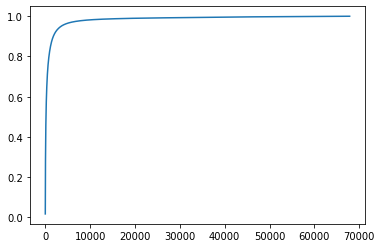

In [127]:
d = word_index_df_df.seq_ravel.cumsum()
#d.tail(1)
ds = word_index_df_df.seq_ravel.sum()) 
(d/().plot.line()
#print ( "Vocab size of 1000 leads to ", word_index_df_df.seq_ravel.cumsum()[1000] , " of " , (word_index_df_df.seq_ravel.sum()) , " words , i.e. ", 100*(word_index_df_df.seq_ravel.cumsum()/(word_index_df_df.seq_ravel.sum()))[1000] , "% ")
#print ( "Vocab size of 2000 leads to ",word_index_df_df.seq_ravel.cumsum()[2000] , " of " , (word_index_df_df.seq_ravel.sum()) , " words , i.e. ", 100*(word_index_df_df.seq_ravel.cumsum()/(word_index_df_df.seq_ravel.sum()))[2000] , "% ")
#print ( "Vocab size of 3000 leads to ",word_index_df_df.seq_ravel.cumsum()[3000] , " of " , (word_index_df_df.seq_ravel.sum()) , " words , i.e. ", 100*(word_index_df_df.seq_ravel.cumsum()/(word_index_df_df.seq_ravel.sum()))[3000] , "% ")

In [2]:
d

NameError: ignored

In [0]:
# tokenizer
tokenizer = Tokenizer(num_words = param_prep['vocab_size'] , oov_token = param_prep['oov_tok'] )
tokenizer.fit_on_texts(train_text1)

In [0]:
# creating sequence of tokens
word_index = tokenizer.word_index
seq = tokenizer.texts_to_sequences(train_text1)

In [0]:
# padding
seq_padded = pad_sequences(seq, padding = 'post' , maxlen = param_prep['max_length'] , truncating = param_prep['trunc_type'] ) 

In [0]:
# creating the train_y data ( dependent variable dataset)
label3 = train_dat2['rating3']

In [0]:
# calling the auxilliary data creation helper function to create the aux input for training.
train_aux = aux_data (train_dat2)

In [0]:
train_aux.head()

,usefulCount,date_year,date_month,date_weekday,D_four,D_onethree,D_twofive,D_zero,C_four,C_threefive,C_two,C_zeroone
0,27,2012,5,6,0,1,0,0,0,0,1,0
1,192,2010,4,1,0,1,0,0,1,0,0,0
2,17,2009,12,0,0,0,1,0,0,0,0,1
3,10,2015,11,1,1,0,0,0,0,0,0,1
4,37,2016,11,6,0,0,0,1,1,0,0,0


In [0]:
label3.head()

0    3
1    3
2    2
3    3
4    3
Name: rating3, dtype: int64

In [0]:
seq_padded[:2]

array([[  10,   16,    8,    3,  518, 2314,   84,   82, 2611, 1263,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [ 532, 2606, 1397,   12, 2575,  306,  629,  269,   54,   12,   13,
           3, 1876,   73,   60,    4,   89,  775,   11,  239, 2652,  654,
         536,  204,   53,  183,  419,  425, 2096, 1611,  319,   33, 1191,
         125,  182,  571,    4,  119,  425,   11,  125,   54,   60,    4,
          86,  303,   4